# Depth estimation with DepthAnything and OpenVINO

[Depth Anything](https://depth-anything.github.io/) is a highly practical solution for robust monocular depth estimation. Without pursuing novel technical modules, this project aims to build a simple yet powerful foundation model dealing with any images under any circumstances.
The framework of Depth Anything is shown below. it adopts a standard pipeline to unleashing the power of large-scale unlabeled images. 
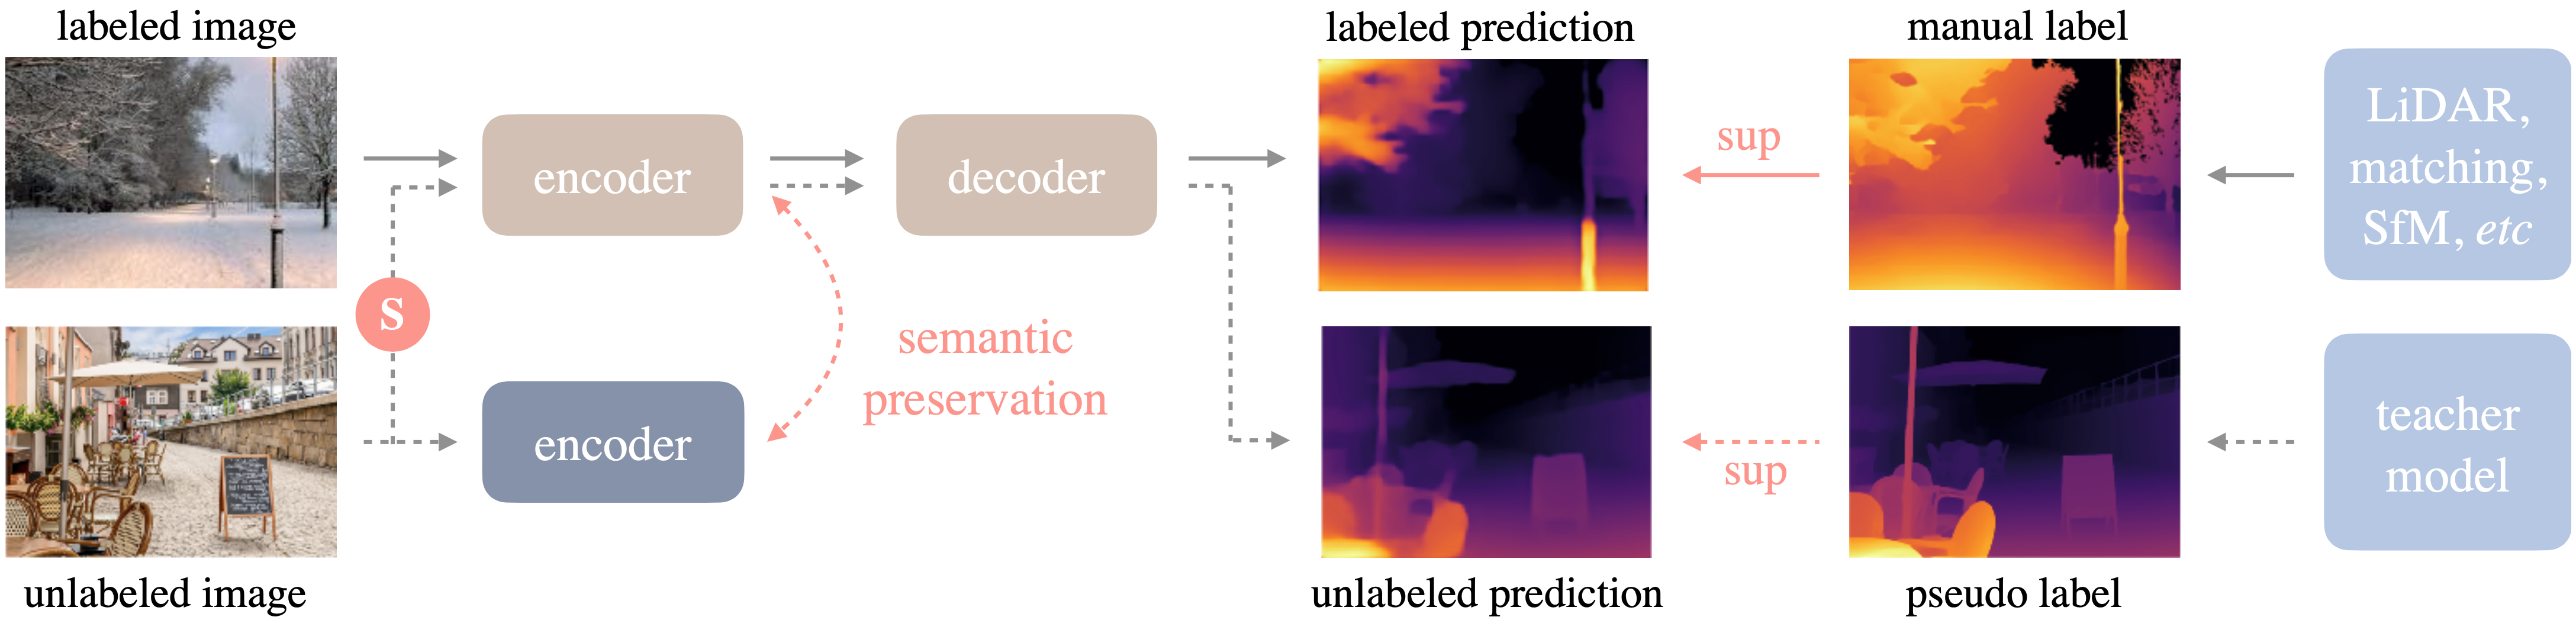

More details about model can be found in [project web page](https://depth-anything.github.io/), [paper](https://arxiv.org/abs/2401.10891) and official [repository](https://github.com/LiheYoung/Depth-Anything)

In this tutorial we will explore how to convert and run DepthAnything using OpenVINO.

## Prerequisites

In [1]:
from pathlib import Path

repo_dir = Path("Depth-Anything")

if not repo_dir.exists():
    !git clone https://github.com/LiheYoung/Depth-Anything
%cd Depth-Anything

%pip install -q "openvino>=2023.2.0"
%pip install -q -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cpu

/home/ea/work/openvino_notebooks/notebooks/281-depth-anything/Depth-Anything
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Load and run PyTorch model

To be able run PyTorch model on CPU, we should disable xformers attention optimizations first.

In [2]:
attention_file_path = Path("./torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py")
orig_attention_path = attention_file_path.parent / ("orig_" + attention_file_path.name)

if not orig_attention_path.exists():
    attention_file_path.rename(orig_attention_path)
    
    with orig_attention_path.open("r") as f:
        data = f.read()
        data = data.replace("XFORMERS_AVAILABLE = True", "XFORMERS_AVAILABLE = False")
        with attention_file_path.open("w") as out_f:
            out_f.write(data)

`DepthAnything.from_pretrained` method creates PyTorch model class instance and load model weights. There are 3 available models in repository depends on VIT encoder size: 
* Depth-Anything-ViT-Small (24.8M)
* Depth-Anything-ViT-Base (97.5M)
* Depth-Anything-ViT-Large (335.3M)

We will use `Depth-Anything-ViT-Small`, but the same steps for running model and converting to OpenVINO are applicable for other models from DepthAnything family.

In [3]:
from depth_anything.dpt import DepthAnything

encoder = 'vits'  # can also be 'vitb' or 'vitl'
model_id = 'depth_anything_{:}14'.format(encoder)
depth_anything = DepthAnything.from_pretrained(f'LiheYoung/{model_id}')

### Prepare input data

'furseal.png' already exists.


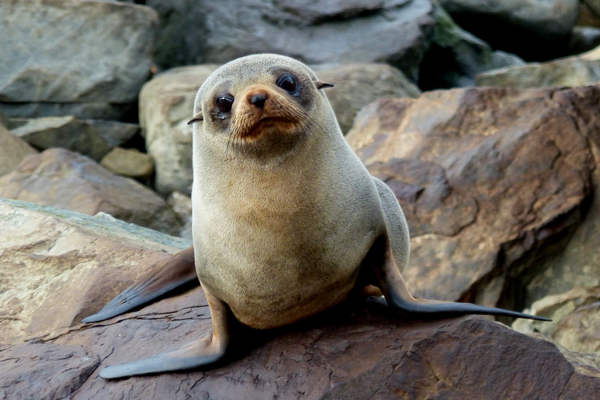

In [4]:
import urllib.request
from PIL import Image


urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file

download_file("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/3f779fc1-c1b2-4dec-915a-64dae510a2bb", "furseal.png")

Image.open("furseal.png").resize((600, 400))

for simplicity of usage, model authors provide helper functions for preprocessing input image. The main conditions are that image size should be divisible on 14 (size of vit patch) and normalized in [0, 1] range.

In [5]:
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

import cv2
import torch

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])


image = cv2.cvtColor(cv2.imread('furseal.png'), cv2.COLOR_BGR2RGB) / 255.0
h, w = image.shape[:-1]
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0)

### Run model inference

Preprocessed image passed to model forward and model returns depth map in format BxHxW, where `B` is input batch size, `H` is preprocessed image height, `W` is preprocessed image width. 

In [6]:
# depth shape: 1xHxW
depth = depth_anything(image)

After image processing finished, we can resize depth map into original image size and prepare it for visualization.

In [7]:
import torch.nn.functional as F
import numpy as np

depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        
depth = depth.cpu().detach().numpy().astype(np.uint8)
depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

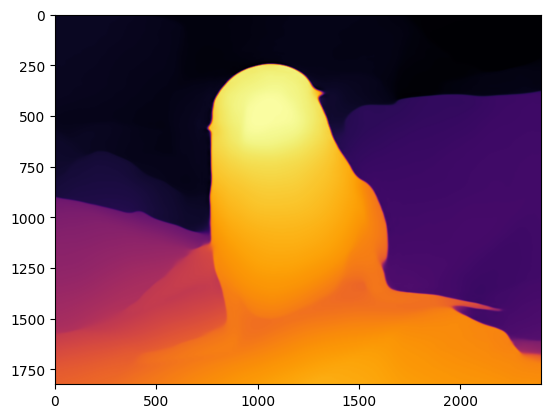

In [8]:
from matplotlib import pyplot as plt

plt.imshow(depth_color[:, :, ::-1]);

## Convert Model to OpenVINO IR format

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). OpenVINO model conversion API should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [9]:
import openvino as ov

OV_DEPTH_ANYTHING_PATH = Path(f'{model_id}.xml') 

if not OV_DEPTH_ANYTHING_PATH.exists():
    ov_model = ov.convert_model(depth_anything, example_input=image, input=[1, 3, 518, 518])
    ov.save_model(ov_model, OV_DEPTH_ANYTHING_PATH)

## Run OpenVINO model inference

Now, we are ready to run OpenVINO model

### Select inference device

For starting work, please select inference device from dropdown list.

In [10]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [11]:
compiled_model = core.compile_model(OV_DEPTH_ANYTHING_PATH, device.value)

### Run inference on image

In [12]:
res = compiled_model(image)[0]

In [13]:
depth = res[0]
depth = cv2.resize(depth, (w, h))
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        
depth = depth.astype(np.uint8)
depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

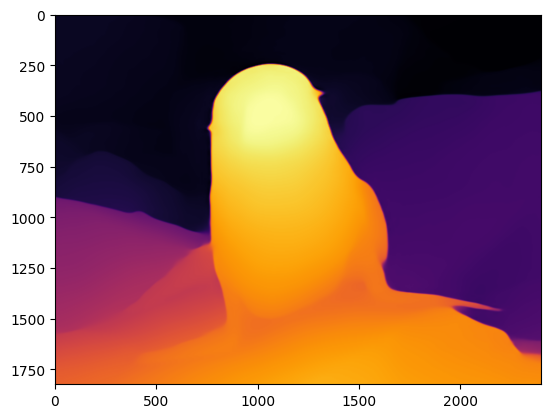

In [14]:
plt.imshow(depth_color[:, :, ::-1]);

### Run inference on video

In [15]:
download_file("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4", "./Coco Walking in Berkeley.mp4")

VIDEO_FILE = "./Coco Walking in Berkeley.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 4
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_depth_anything.mp4"

'Coco Walking in Berkeley.mp4' already exists.


In [16]:
cap = cv2.VideoCapture(str(VIDEO_FILE))
ret, image = cap.read()
if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")
input_fps = cap.get(cv2.CAP_PROP_FPS)
input_video_frame_height, input_video_frame_width = image.shape[:2]

target_fps = input_fps / ADVANCE_FRAMES
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(
    f"The input video has a frame width of {input_video_frame_width}, "
    f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps"
)
print(
    "The output video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 360 and runs at 30.00 fps
The output video will be scaled with a factor 0.5, have width 320,  height 180, and run at 15.00 fps


In [17]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = result * 255
    result = result.astype(np.uint8)
    result = cv2.applyColorMap(result, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

In [18]:
import time
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)

# Initialize variables.
input_video_frame_nr = 0
start_time = time.perf_counter()
total_inference_duration = 0

# Open the input video
cap = cv2.VideoCapture(str(VIDEO_FILE))

# Create a result video.
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    target_fps,
    (target_frame_width * 2, target_frame_height),
)

num_frames = int(NUM_SECONDS * input_fps)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if input_video_frame_nr >= total_frames:
            break

        h, w = image.shape[:-1]
        input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
        input_image = transform({'image': input_image})['image']
        # Reshape the image to network input shape NCHW.
        input_image = np.expand_dims(input_image, 0)

        # Do inference.
        inference_start_time = time.perf_counter()
        result = compiled_model(input_image)[0]
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
            clear_output(wait=True)
            progress_bar.display()
            # input_video_frame_nr // ADVANCE_FRAMES gives the number of
            # Frames that have been processed by the network.
            display(
                Pretty(
                    f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                    f"/{total_frames // ADVANCE_FRAMES}. "
                    f"Inference time per frame: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )

        # Transform the network result to a RGB image.
        result_frame = to_rgb(convert_result_to_image(result))
        # Resize the image and the result to a target frame shape.
        result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
        image = cv2.resize(image, (target_frame_width, target_frame_height))
        # Put the image and the result side by side.
        stacked_frame = np.hstack((image, result_frame))
        # Save a frame to the video.
        out_video.write(stacked_frame)

        input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
        cap.set(1, input_video_frame_nr)

        progress_bar.progress = input_video_frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
finally:
    clear_output()
    processed_frames = num_frames // ADVANCE_FRAMES
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time

    print(
        f"Processed {processed_frames} frames in {duration:.2f} seconds. "
        f"Total FPS (including video processing): {processed_frames/duration:.2f}."
        f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
    )
    print(f"Video saved to '{str(result_video_path)}'.")

Processed 60 frames in 15.57 seconds. Total FPS (including video processing): 3.85.Inference FPS: 8.24 
Video saved to 'output/Coco Walking in Berkeley_depth_anything.mp4'.


In [19]:
video = Video(result_video_path, width=800, embed=True)
if not result_video_path.exists():
    plt.imshow(stacked_frame)
    raise ValueError("OpenCV was unable to write the video file. Showing one video frame.")
else:
    print(f"Showing video saved at\n{result_video_path.resolve()}")
    print(
        "If you cannot see the video in your browser, please click on the "
        "following link to download the video "
    )
    video_link = FileLink(result_video_path)
    video_link.html_link_str = "<a href='%s' download>%s</a>"
    display(HTML(video_link._repr_html_()))
    display(video)

Showing video saved at
/home/ea/work/openvino_notebooks/notebooks/281-depth-anything/Depth-Anything/output/Coco Walking in Berkeley_depth_anything.mp4
If you cannot see the video in your browser, please click on the following link to download the video 


## Interactive demo

You can apply model on own images. You can move the slider on the resulting image to switch between the original image and the depth map view.

In [ ]:
import gradio as gr
import cv2
import numpy as np
import os
import tempfile
from gradio_imageslider import ImageSlider

css = """
#img-display-container {
    max-height: 100vh;
    }
#img-display-input {
    max-height: 80vh;
    }
#img-display-output {
    max-height: 80vh;
    }
"""


title = "# Depth Anything with OpenVINO"


def predict_depth(model, image):
    return model(image)[0]

with gr.Blocks(css=css) as demo:
    gr.Markdown(title)
    gr.Markdown("### Depth Prediction demo")
    gr.Markdown("You can slide the output to compare the depth prediction with input image")

    with gr.Row():
        input_image = gr.Image(label="Input Image", type='numpy', elem_id='img-display-input')
        depth_image_slider = ImageSlider(label="Depth Map with Slider View", elem_id='img-display-output', position=0)
    raw_file = gr.File(label="16-bit raw depth (can be considered as disparity)")
    submit = gr.Button("Submit")

    def on_submit(image):
        original_image = image.copy()

        h, w = image.shape[:2]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
        image = transform({'image': image})['image']
        image = np.expand_dims(image, 0)

        depth = predict_depth(compiled_model, image)
        depth = cv2.resize(depth[0], (w, h), interpolation=cv2.INTER_LINEAR)

        raw_depth = Image.fromarray(depth.astype('uint16'))
        tmp = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
        raw_depth.save(tmp.name)

        depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        depth = depth.astype(np.uint8)
        colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

        return [(original_image, colored_depth), tmp.name]

    submit.click(on_submit, inputs=[input_image], outputs=[depth_image_slider, raw_file])

    example_files = os.listdir('assets/examples')
    example_files.sort()
    example_files = [os.path.join('assets/examples', filename) for filename in example_files]
    examples = gr.Examples(examples=example_files, inputs=[input_image], outputs=[depth_image_slider, raw_file], fn=on_submit, cache_examples=False)


if __name__ == '__main__':
    try:
        demo.queue().launch(debug=True)
    except Exception:
        demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/